# Тестовое задание для "BostonGene"</br>
#### Дмитрий Зарубин

## 1. Сгенерировать набор данных
> Для создания набора использовал набор функций из "data_utils.py", затем сохранил сгененированные картинки и маски в 2 папки "Iamges" и "Masks"

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import dataset_utils

IMG_H = 160
IMG_W = 160
n_train = 5000
n_val = 500
n_test = 1000

batch_size = 24
num_workers = 2

ROOT = '../Segmentation_Data/Train'

In [4]:
# dataset_utils.create_dataset(
#     height=IMG_H, 
#     width=IMG_W, 
#     n_train=n_train,
#     n_val=n_val,
#     n_test=n_test,
#     root='../')

Directory |../Segmentation_Data|
Already exists! It will be removed
100%|██████████| 1000/1000 [00:05<00:00, 187.09it/s]


> Посмотрим что получилось:

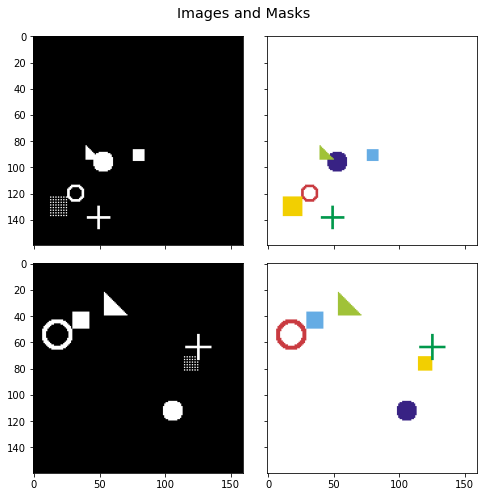

In [2]:
dataset_utils.plot_img_n_masks(ROOT, 2)

## 2.1. Инициализация Dataset и DataLoader

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[.0, .0, .0], 
        std=[1., 1., 1.])

])

train_set = dataset_utils.Segmentation_Dataset('../Segmentation_Data/Train/', transforms=norm)
val_set = dataset_utils.Segmentation_Dataset('../Segmentation_Data/Val/', transforms=norm)

train_loader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers
)

val_loader = DataLoader(
    dataset=val_set, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers
)

image_datasets = {
    'train': train_set, 'val': val_set
}

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [3]:
def reverse_transform(img):
    img = img.numpy().transpose([1, 2, 0])
    img = (img * 255).astype(np.uint8)
    return img

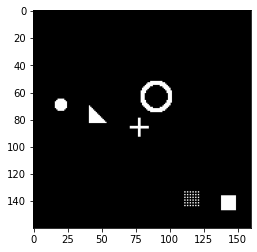

In [5]:
inputs, masks = next(iter(train_loader))

plt.imshow(reverse_transform(inputs[np.random.randint(0, batch_size-1, 1)][0]))
plt.show()

## 2.2. Модель
> В качестве алгоритма для классификации была выбрана модель Unet с уменьшенным количеством фильтров в каждом слое и немного измененными параметрами свертки. </br>Глобально: меньшее кол-во фильтров,так как сегментироваться будут не столь "абстрактные" обьекты, измененные параметры свертки - чтобы не кропать изображение во время конкатенации слоев.

In [4]:
from torchsummary import summary
import torch
import torch.nn as nn
import unet

device = 'cuda'

model = unet.UNet().to(device)

summary(model, input_size=(3, IMG_H, IMG_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 160, 160]             432
       BatchNorm2d-2         [-1, 16, 160, 160]              32
              ReLU-3         [-1, 16, 160, 160]               0
            Conv2d-4         [-1, 16, 160, 160]           2,304
       BatchNorm2d-5         [-1, 16, 160, 160]              32
              ReLU-6         [-1, 16, 160, 160]               0
         MaxPool2d-7           [-1, 16, 80, 80]               0
            Conv2d-8           [-1, 32, 80, 80]           4,608
       BatchNorm2d-9           [-1, 32, 80, 80]              64
             ReLU-10           [-1, 32, 80, 80]               0
           Conv2d-11           [-1, 32, 80, 80]           9,216
      BatchNorm2d-12           [-1, 32, 80, 80]              64
             ReLU-13           [-1, 32, 80, 80]               0
        MaxPool2d-14           [-1, 32,

In [6]:
import torch.optim as optim
from torch.optim import lr_scheduler

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()
scheduler = lr_scheduler.StepLR(optimizer, step_size=batch_size, gamma=0.1)
num_epochs = 5

In [7]:
from train import *

model = train_model(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)

Epoch 0/4
----------
LR 0.001
train: bce loss: 0.320627, dice loss: 0.979639
val: bce loss: 0.116888, dice loss: 0.967773
=> Saving checkpoint
0m 31s
Epoch 1/4
----------
LR 0.001
train: bce loss: 0.060675, dice loss: 0.938295
val: bce loss: 0.033525, dice loss: 0.908217
0m 32s
Epoch 2/4
----------
LR 0.001
train: bce loss: 0.022830, dice loss: 0.861979
val: bce loss: 0.016473, dice loss: 0.822329
0m 32s
Epoch 3/4
----------
LR 0.001
train: bce loss: 0.013252, dice loss: 0.784687
val: bce loss: 0.011347, dice loss: 0.750537
0m 32s
Epoch 4/4
----------
LR 0.001
train: bce loss: 0.009124, dice loss: 0.704238
val: bce loss: 0.007540, dice loss: 0.657337
0m 32s
Best val loss: 0.000000


(4, 6, 160, 160)


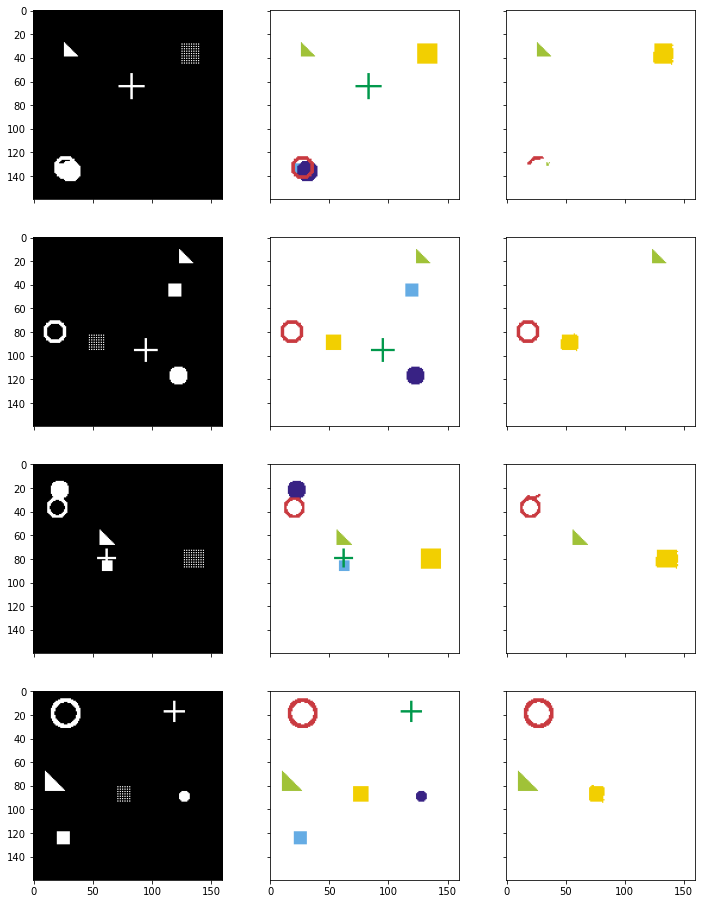

In [9]:
import math
import data_utils

model.eval()   # Set model to evaluate mode

test_dataset = dataset_utils.Segmentation_Dataset('../Segmentation_Data/Test/', transforms=norm)
indices = torch.randperm(len(test_dataset)).tolist()
#test_dataset = torch.utils.data.Subset(test_dataset, indices[:3])
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to('cuda')
labels = labels.to('cuda')

pred = torch.sigmoid(model(inputs))

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot

# Map each channel (i.e. class) to each color

input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]
target_masks_rgb = [data_utils.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [data_utils.masks_to_colorimg(x) for x in pred]

data_utils.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [11]:
labels = labels.cpu().numpy()

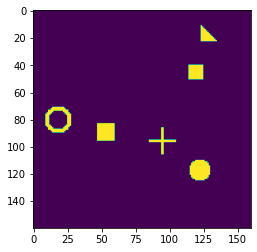

In [12]:
plt.imshow(np.max(labels[1], axis=0))

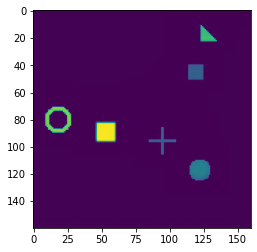

In [13]:
plt.imshow(np.max(pred[1], axis=0))

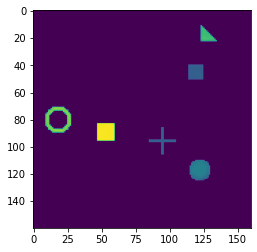

In [14]:
plt.imshow(np.sum(pred[1]*labels[1], axis=0))

In [15]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()  

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [16]:
dice_loss(torch.as_tensor(labels).cpu(), torch.as_tensor(pred))

tensor(0.4102)

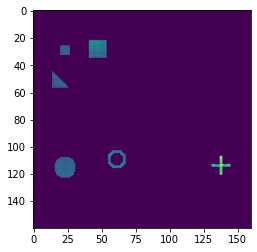

In [70]:
plt.imshow(dice_coef(labels[0], pred[0]))

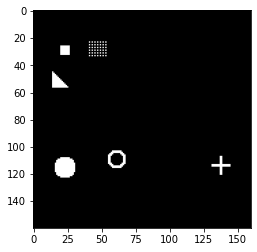

In [19]:
plt.imshow(reverse_transform(inputs[0].cpu()))

In [12]:
import data_utils

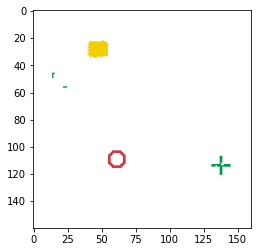

In [14]:
p_masks = [data_utils.masks_to_colorimg(x) for x in pred]
plt.imshow(p_masks[0])

In [23]:
import data_utils